In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from fpdf import FPDF

In [13]:
data = pd.read_csv('malaysia_parcel_volumes_2.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
# Linear Regression
X_lr = data.index.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)
y_lr = data['Parcel Volume'].values
regression_lr = LinearRegression()
regression_lr.fit(X_lr, y_lr)
y_lr_pred = regression_lr.predict(X_lr)

In [15]:
# ARIMA
model_arima = ARIMA(data['Parcel Volume'], order=(2, 0, 2))
model_fit = model_arima.fit()
predictions_arima = model_fit.predict(start='2022-01-01', end='2024-03-01')

C:\Users\admin\anaconda3.1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3.1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3.1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
# Random Forest Regressor
X_rf = data.index.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)  # Corrected conversion
y_rf = data['Parcel Volume'].values
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)
predictions_rf = rf_model.predict(X_rf)

In [17]:
# Prophet
data_prophet = data.reset_index().rename(columns={'Date': 'ds', 'Parcel Volume': 'y'})
model_prophet = Prophet()
model_prophet.fit(data_prophet)
future_dates = model_prophet.make_future_dataframe(periods=16, freq='M')
forecast = model_prophet.predict(future_dates)
predictions_prophet = forecast[['ds', 'yhat']].tail(9).round(0)

17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\admin\anaconda3.1\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


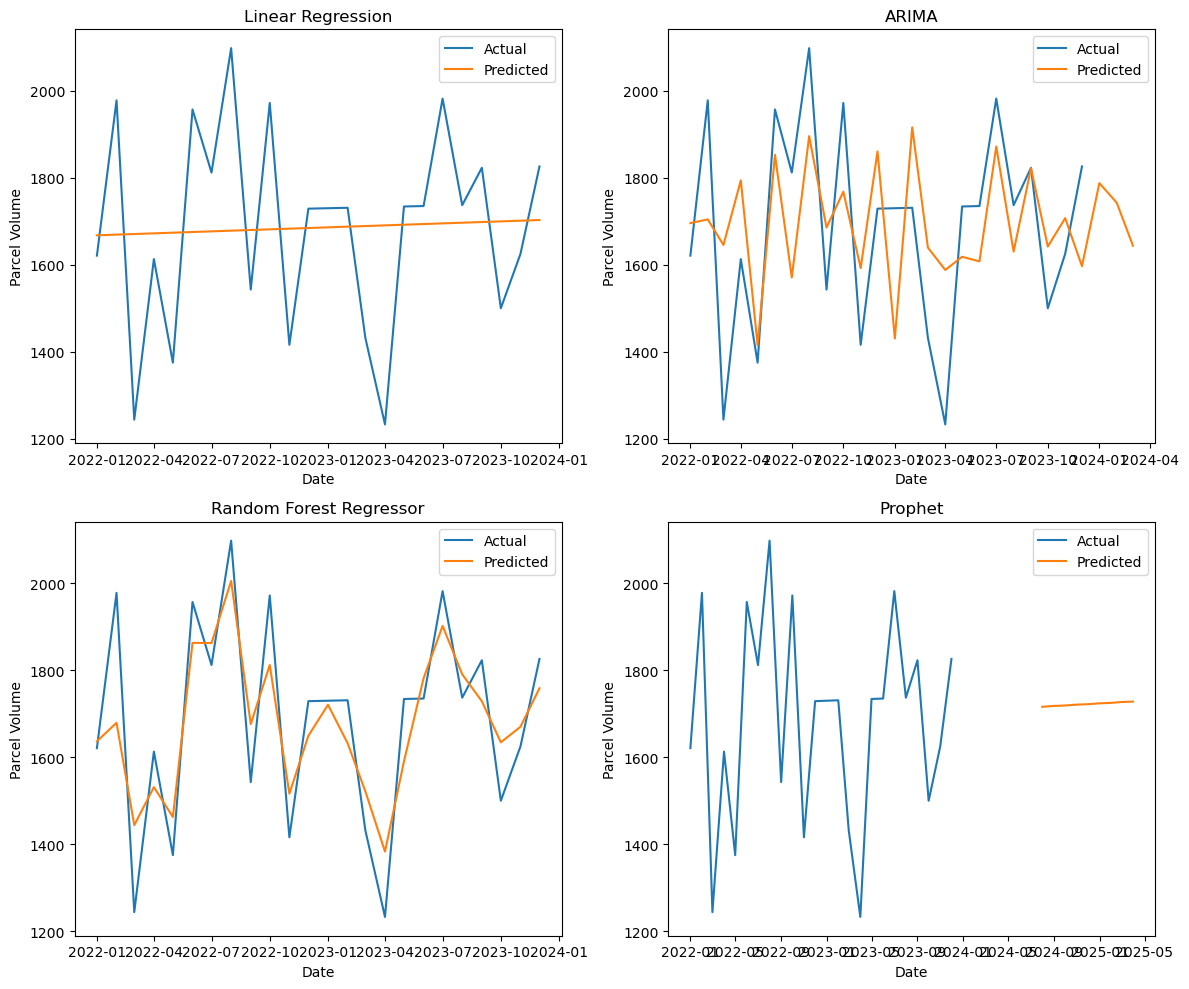

In [18]:
fiq, axs = plt.subplots(2,2, figsize=(12,10))
# Linear Regression
axs[0, 0].plot(data.index, data['Parcel Volume'], label='Actual')
axs[0, 0].plot(data.index, y_lr_pred, label='Predicted')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Parcel Volume')
axs[0, 0].legend()

# ARIMA
axs[0, 1].plot(data['Parcel Volume'], label='Actual')
axs[0, 1].plot(predictions_arima, label='Predicted')
axs[0, 1].set_title('ARIMA')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Parcel Volume')
axs[0, 1].legend()

# Random Forest Regressor
axs[1, 0].plot(data.index, data['Parcel Volume'], label='Actual')
axs[1, 0].plot(data.index, predictions_rf, label='Predicted')
axs[1, 0].set_title('Random Forest Regressor')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Parcel Volume')
axs[1, 0].legend()

# Prophet
axs[1, 1].plot(data_prophet['ds'], data_prophet['y'], label='Actual')
axs[1, 1].plot(predictions_prophet['ds'], predictions_prophet['yhat'], label='Predicted')
axs[1, 1].set_title('Prophet')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Parcel Volume')
axs[1, 1].legend()

# Adjust the layout
plt.tight_layout()

# Save the plot as an image
plt.savefig('parcel_volume_forecasting_graphs.png')

In [19]:
# Calculate MSE and MAE for each model
mse_lr = mean_squared_error(data['Parcel Volume'], y_lr_pred)
mae_lr = mean_absolute_error(data['Parcel Volume'], y_lr_pred)

# Option 1: Trim predictions to match the true values
predictions_arima_trimmed = predictions_arima[:24]

# Then calculate metrics
mse_arima = mean_squared_error(data['Parcel Volume'].loc['2022-01-01':'2024-01-01'], predictions_arima_trimmed)
mae_arima = mean_absolute_error(data['Parcel Volume'].loc['2022-01-01':'2024-01-01'], predictions_arima_trimmed)

mse_rf = mean_squared_error(data['Parcel Volume'], predictions_rf)
mae_rf = mean_absolute_error(data['Parcel Volume'], predictions_rf)

mse_prophet = mean_squared_error(data_prophet['y'].tail(9), predictions_prophet['yhat'].tail(9))
mae_prophet = mean_absolute_error(data_prophet['y'].tail(9), predictions_prophet['yhat'].tail(9))

In [20]:
# Generate PDF report
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'K-Youth - Forecasting Python - Parcel Volume', ln=True, align='C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

In [21]:
# Create PDF document
pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

In [22]:
# Report Title
pdf.set_font('Arial', 'B', 16)
pdf.cell(200, 10, txt="Parcel Volume Forecasting", ln=True, align='C')
pdf.ln(10)

# Section 1: Introduction
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="1. Introduction", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="In this report, we analyze the parcel volume data to forecast future trends using multiple machine learning techniques including Linear Regression, ARIMA, Random Forest Regressor, and Prophet. The data used spans several years, and the goal is to provide a reliable forecast based on the model performances.")

pdf.ln(5)

# Section 2: Data Overview
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="2. Data Overview", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The dataset contains parcel volume data over time. The dataset was preprocessed and time-indexed to make it suitable for time-series forecasting. Date values were converted to ordinal integers for models requiring numerical input.")

pdf.ln(5)

# Section 3: Modeling Techniques
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="3. Modeling Techniques", ln=True)
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.1 Linear Regression", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Linear Regression is a basic and interpretable model that attempts to capture the linear relationship between the time index and the parcel volume. This model is straightforward, but may not capture complex patterns in time-series data.")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.2 ARIMA", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="ARIMA is a popular statistical method for time-series forecasting that captures both trend and seasonality. In this case, we used an ARIMA(2,0,2) model to capture the relationships in the parcel volume data.")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.3 Random Forest Regressor", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The Random Forest Regressor is an ensemble learning method that can capture complex non-linear relationships. By using multiple decision trees, it can provide robust predictions, especially in diverse datasets.")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="3.4 Prophet", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Prophet is a forecasting tool designed for business time-series data. It is robust to missing data and shifts in the trend, and it automatically detects seasonal patterns.")

# Section 4: Model Evaluation
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="4. Model Evaluation", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="The performance of the models was evaluated using Mean Squared Error (MSE) and Mean Absolute Error (MAE). The results are as follows:")

# Evaluation metrics
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Linear Regression", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="ARIMA", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_arima:.2f}, MAE: {mae_arima:.2f}")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Random Forest Regressor", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, txt="Prophet", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt=f"MSE: {mse_prophet:.2f}, MAE: {mae_prophet:.2f}")

# Add graphs to PDF
pdf.add_page()
pdf.image('parcel_volume_forecasting_graphs.png', x=10, y=30, w=190)  # Adjust x and y as necessary

# Section 5: Conclusion
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, txt="5. Conclusion", ln=True)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, txt="Based on the evaluation metrics, we observe that each model has its strengths and weaknesses. The Random Forest Regressor shows promise in capturing non-linear relationships, while ARIMA provides a good fit for time series with trend and seasonality. The choice of model may depend on the specific requirements of accuracy, interpretability, and computational resources.")

# Save PDF
pdf.output('parcel_volume_forecasting_report.pdf')

print("PDF report generated successfully.")

PDF report generated successfully.
